<a href="https://colab.research.google.com/github/gawayne29/gawayneLessons/blob/main/newFiles/Chills%20Analysis%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Import Github repo files

In [2]:
!git clone https://github.com/jcdevaney/gawayneLessons.git

Cloning into 'gawayneLessons'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 121 (delta 16), reused 12 (delta 12), pack-reused 100
Receiving objects: 100% (121/121), 30.30 MiB | 25.37 MiB/s, done.
Resolving deltas: 100% (36/36), done.


# Load audio file

In [3]:
file = '/content/gawayneLessons/files/r0.wav'
sig , sr = librosa.load(file,mono=True,sr=None)

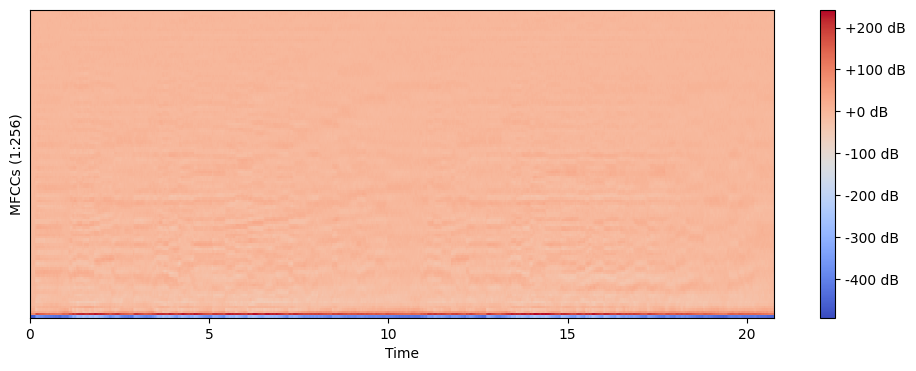

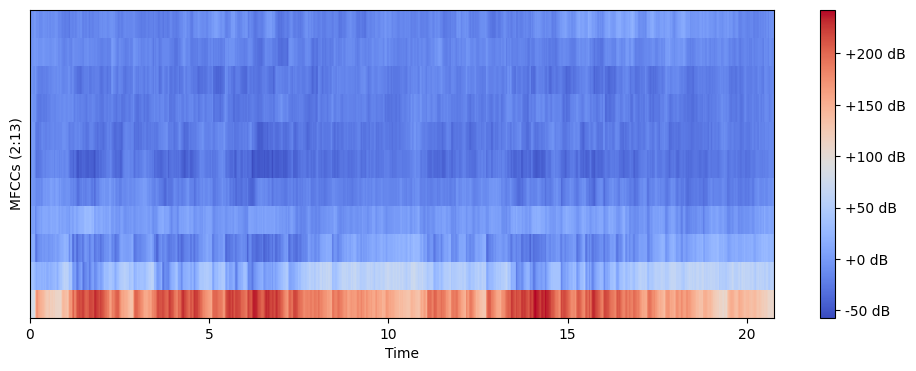

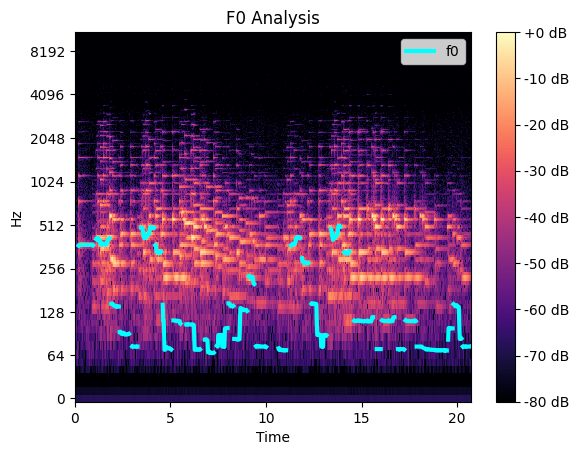

TypeError: ignored

In [35]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
filename = '/content/gawayneLessons/files/r0.wav'

def chills_analysis(audio_file):
    # Load audio file
    y, sr = librosa.load('/content/gawayneLessons/files/r0.wav')

    # MFCC analysis
    hop_length = 512
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=256)

    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.ylabel('MFCCs (1:256)')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mfcc[1:12, :], x_axis='time')
    plt.ylabel('MFCCs (2:13)')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

    # F0 analysis
    audio_vals = analyze_audio(audio_file)
    plot_audio_vals(audio_vals, audio_file, 'F0 Analysis', 'f0')

    # Onsets analysis
    get_onsets_wrapper(audio_file)

    # Beat tracking
    beat_tracking(audio_file)

def analyze_audio(audio_path):
    audio_vals = {}
    y, sr = librosa.load('/content/gawayneLessons/files/r0.wav')
    audio_vals['specCent'] = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=2048, hop_length=512, freq=None)
    audio_vals['specBand'] = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=2048, hop_length=512, freq=None)
    audio_vals['specContrast'] = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=2048, hop_length=512, freq=None)
    audio_vals['specFlatness'] = librosa.feature.spectral_flatness(y=y)

    audio_vals['f0'], _, _ = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    audio_vals['f0mean'] = np.nanmean(audio_vals['f0'])

    return audio_vals

def plot_audio_vals(audio_vals, audio_path, plot_title, data_name):
    y, sr = librosa.load('/content/gawayneLessons/files/r0.wav')
    times = librosa.times_like(audio_vals[data_name])
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
    ax.set(title=plot_title)
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    ax.plot(times, audio_vals[data_name], label=data_name, color='cyan', linewidth=3)
    ax.legend(loc='upper right')
    plt.show()

def get_onsets_wrapper(filename):
    sig, sr = librosa.load(filename, mono=True, sr=None)
    onset_frames = get_onsets_env(sig, sr)
    print('Estimated onsets:')
    print(librosa.frames_to_time(onset_frames, sr=sr))

def beat_tracking(filename):
    y, sr = librosa.load(filename)
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

    y_harmonic, y_percussive = librosa.effects.hpss(y)
    C = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)

    tempo, beats = librosa.beat.beat_track(y=y_percussive, sr=sr)

    plt.figure(figsize=(12, 4))
    librosa.display.specshow(M)
    plt.title('MFCC-$\Delta$-$\Delta^2$')
    plt.yticks(np.arange(0, M.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(12, 4))
    librosa.display.specshow(librosa.util.sync(C, beats, aggregate=np.median), y_axis='chroma')
    plt.title('Beat-synchronous Chroma (median aggregation)')
    plt.colorbar()
    plt.show()


def get_onsets_env(sig, sr=44100):
    o_env = librosa.onset.onset_strength(sig, sr=sr)
    times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
    onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

    D = np.abs(librosa.stft(sig, n_fft=4096))
    plt.figure()
    ax1 = plt.subplot(2, 1, 1)
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), hop_length=512, x_axis='time', y_axis='log')
    plt.title('Estimated from Onset Envelope')
    plt.subplot(2, 1, 2, sharex=ax1)
    plt.plot(times, o_env, label='Onset strength')
    plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9, linestyle='--', label='Onsets')
    plt.axis('tight')
    plt.legend(frameon=True, framealpha=0.75)

    return onset_frames

def getOnsetsWrapper(filename):
    sig , sr = librosa.load(filename,mono=True,sr=None)

    # estimate onsets from an onset envelope
    onset_frames = getOnsetsEnv(sig,sr)
    print('Estimated onsets:')
    print(librosa.frames_to_time(onset_frames, sr=sr))

audio_file_path = '/content/gawayneLessons/files/r0.wav'
chills_analysis(audio_file_path)
